# 1. BOW(Bag Of Words) 기반의 랜덤 포레스트 분류 모델 구축

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from scipy.stats import randint
from sklearn.feature_selection import chi2, SelectKBest
import re
from xgboost import XGBClassifier


train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_data/train_40k.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_data/val_10k.csv')

In [4]:
train.columns

Index(['productId', 'Title', 'userId', 'Helpfulness', 'Score', 'Time', 'Text',
       'Cat1', 'Cat2', 'Cat3'],
      dtype='object')

## 1-1. 텍스트 토큰화 작업

In [5]:
X_train = train['Text']
y_train1 = train[['Cat1']]
y_train2 = train[['Cat2']]

X_test = test['Text']
y_test1 = test[['Cat1']]
y_test2 = test[['Cat2']]

In [6]:
nlp = spacy.load('en_core_web_sm')

def tokenize(text):

    doc = nlp(text)

    token = ' '.join([token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)
    and (token.is_alpha == True)])
    
    return token

In [7]:
def tokenize_re(text):
    regex = r"[^a-zA-Z ]"
    tokens = re.sub(regex, '', text)

    tokens = tokens.lower().split()
    

    return tokens

In [36]:
X_train

0        description photo product need change indicate...
1        great book think easily imagine event happen w...
2        year teacher teach grade special reading class...
3        get book bookfair school look summer turn read...
4        hi martine redman create puzzle briarpatch gre...
                               ...                        
39995    convenient find small store tiny lipstick squa...
39996    wore day eat chinese ankle go inch purchase pl...
39997       ok product stay fog free long useful well sure
39998    glitter body lotion offer tremendous sparkle a...
39999    disappointed scent fragrance smell cheap needl...
Name: Text, Length: 40000, dtype: object

In [8]:
X_train = X_train.apply(tokenize)
X_test = X_test.apply(tokenize)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


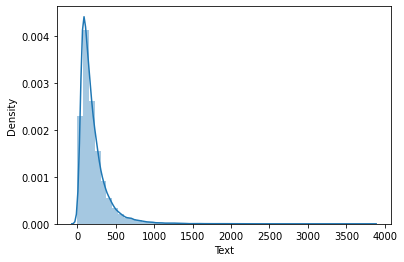

In [6]:
import seaborn as sns

sns.distplot(X_train.apply(len));

## 1-2. RandomForest 모델 비교

In [73]:
vect = TfidfVectorizer(stop_words = 'english',
                       ngram_range = (1, 2),
                       max_df = 0.65,
                       min_df = 3)

chi = SelectKBest(chi2, k = 10000)

rfc = RandomForestClassifier(random_state=411)



pipe = Pipeline([
                        ('vect', vect),
                        ('chi', chi),
                        ('rfc', rfc)
])

In [91]:
pipe.fit(X_train, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.65, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [114]:
pipe.score(X_train, y_train1)

0.997675

In [48]:
pipe.score(X_test, y_test1)

0.7488

In [82]:
from sklearn.model_selection import RandomizedSearchCV

parameter = {'vect__max_df' : (0.5, 0.7, 0.9),
             'vect__min_df' : (1, 2, 3, 4, 5),
             'vect__max_features' : (5000, 8000, 10000, 12000),
             'chi__k' : (3000, 5000, 7000, 10000, 12000)
             }

model = RandomizedSearchCV(pipe,
                         param_distributions = parameter,
                         n_iter = 10,
                         cv = 3,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

model.fit(X_train, y_train1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.65,
                                                              max_features=None,
                                                              min_df=3,
                                                       

In [78]:
model.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=12000,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [88]:
best = model.best_estimator_
y_pred = best.predict(X_test)
print('Randomized CV 테스트 정확도 : ', accuracy_score(y_test1, y_pred))

Randomized CV 테스트 정확도 :  0.7422


In [49]:
from sklearn.feature_selection import chi2 as chi

vect2 = TfidfVectorizer(stop_words = 'english',
                       ngram_range = (1, 2),
                       max_df = 0.65,
                       min_df = 3)

chi2 = SelectKBest(chi, k = 10000)

rfc2 = RandomForestClassifier(random_state=411)

pipe_64 = Pipeline([
                        ('vect2', vect2),
                        ('chi2', chi2),
                        ('rfc2', rfc2)
])

In [50]:
pipe_64.fit(X_train, y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('vect2',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.65, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [53]:
pipe_64.score(X_train, y_train2)

0.99555

In [51]:
pipe_64.score(X_test, y_test2)

0.5361

In [85]:
parameter = {'vect2__max_df' : (0.5, 0.7, 0.9),
             'vect2__min_df' : (1, 2, 3, 4, 5),
             'vect2__max_features' : (5000, 8000, 10000, 12000),
             'chi2__k' : (3000, 5000, 7000, 10000, 12000)
             }

model_64 = RandomizedSearchCV(pipe_64,
                         param_distributions = parameter,
                         n_iter = 10,
                         cv = 3,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

model_64.fit(X_train, y_train2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect2',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.65,
                                                              max_features=None,
                                                              min_df=3,
                                                      

In [87]:
best64 = model_64.best_estimator_
y_pred64 = best64.predict(X_test)
print('Randomized CV 테스트 정확도 : ', accuracy_score(y_test2, y_pred64))

Randomized CV 테스트 정확도 :  0.5351


In [92]:
cat1_pipe_train = pipe.score(X_train, y_train1)
cat1_pipe_test = pipe.score(X_test, y_test1)

cat1_cv_train = best.score(X_train, y_train1)
cat1_cv_test = best.score(X_test, y_test1)

In [96]:
cat2_pipe_train = pipe_64.score(X_train, y_train2)
cat2_pipe_test = pipe_64.score(X_test, y_test2)

cat2_cv_train = best64.score(X_train, y_train2)
cat2_cv_test = best64.score(X_test, y_test2)

In [106]:
train_score = [cat1_pipe_train, cat1_cv_train, cat2_pipe_train, cat2_cv_train]
test_score = [cat1_pipe_test, cat1_cv_test, cat2_pipe_test, cat2_cv_test]
score_index = ['Cat1_PIPE', 'Cat1_CV', 'Cat2_PIPE', 'Cat2_CV']

In [108]:
score_index

['Cat1_PIPE', 'Cat1_CV', 'Cat2_PIPE', 'Cat2_CV']

In [109]:
train_score

[0.997675, 0.9979, 0.99555, 0.99735]

In [115]:
score = pd.DataFrame(score_index, columns = ['Model'])
score['Train'] = train_score
score['Test'] = test_score
score

,Model,Train,Test
0,Cat1_PIPE,0.997675,0.7488
1,Cat1_CV,0.997900,0.7422
2,Cat2_PIPE,0.995550,0.5361
3,Cat2_CV,0.997350,0.5351


# 랜덤 포레스트 결론 
## TEST 검증 결과, CAT1의 경우, Class가 6개였기 때문에 다소 높은 약 75%의 정확도가 나왔다. 반면에, CAT2의 경우 클래스가 64개이기 때문에 다중 분류 형태로 일반화할 수 없을 정도의 53%의 정확도가 나왔다. 우선적으로, CAT2는 랜덤 포레스트 모델을 사용할 수 없으며, CAT1의 경우 딥러닝 모델과 성능 비교를 통해 어느 모델을 이용할지 선택하도록 하겠다.

In [117]:
model.best_params_

{'chi__k': 7000,
 'vect__max_df': 0.9,
 'vect__max_features': 12000,
 'vect__min_df': 5}

In [11]:
tfidf = TfidfVectorizer(stop_words = 'english',
                       ngram_range = (1, 2),
                       max_df = 0.9,
                       min_df = 5,
                        max_features = 12000)

dtm = tfidf.fit_transform(X_train)
dtm = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
dtm

,aa,aa battery,aaa,aaa battery,abc,ability,able,able buy,able eat,able figure,able fit,able order,able play,able pump,able purchase,able remove,able sit,able sleep,able use,able walk,able work,abrasive,absolute,absolute favorite,absolute good,absolutely,absolutely adorable,absolutely adore,absolutely amazing,absolutely delicious,absolutely good,absolutely love,absolutely perfect,absolutely wonderful,absolutly,absolutly love,absorb,absorbant,absorbency,absorbent,...,young child,young daughter,young girl,young kid,young old,young son,young toddler,youngblood,youth,youthful,youtube,yr,yr old,yrs,yrs old,yu,yu gi,yuck,yucky,yugioh,yum,yummy,zap,zero,zero star,zico,zinc,zip,ziploc,ziploc bag,ziplock,zipper,zippo,zoid,zombie,zone,zoo,zoom,zoya,zum
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.151087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144005,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [12]:
dtm_test = tfidf.transform(X_test)
dtm_test = pd.DataFrame(dtm_test.todense(), columns = tfidf.get_feature_names())

dtm_test

,aa,aa battery,aaa,aaa battery,abc,ability,able,able buy,able eat,able figure,able fit,able order,able play,able pump,able purchase,able remove,able sit,able sleep,able use,able walk,able work,abrasive,absolute,absolute favorite,absolute good,absolutely,absolutely adorable,absolutely adore,absolutely amazing,absolutely delicious,absolutely good,absolutely love,absolutely perfect,absolutely wonderful,absolutly,absolutly love,absorb,absorbant,absorbency,absorbent,...,young child,young daughter,young girl,young kid,young old,young son,young toddler,youngblood,youth,youthful,youtube,yr,yr old,yrs,yrs old,yu,yu gi,yuck,yucky,yugioh,yum,yummy,zap,zero,zero star,zico,zinc,zip,ziploc,ziploc bag,ziplock,zipper,zippo,zoid,zombie,zone,zoo,zoom,zoya,zum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [16]:
svd = TruncatedSVD(n_components=5000)

In [17]:
X_train_svd = svd.fit_transform(dtm)
X_test_svd = svd.transform(dtm_test)

In [129]:
X_train_svd

array([[ 0.07248014, -0.07371376,  0.02414633, ...,  0.00771281,
        -0.01338042, -0.02154955],
       [ 0.09680868,  0.05250635,  0.11681931, ..., -0.03398687,
         0.01793955, -0.00730386],
       [ 0.1124973 ,  0.02001545,  0.02329623, ..., -0.03438898,
         0.02805326, -0.03787112],
       ...,
       [ 0.09210653, -0.07690768,  0.01747744, ...,  0.03031769,
        -0.0058908 ,  0.03087857],
       [ 0.1035529 , -0.08514187,  0.02325495, ..., -0.01586816,
        -0.03567031, -0.01006093],
       [ 0.11362888, -0.0499431 , -0.000907  , ...,  0.0223271 ,
        -0.03256618,  0.02944978]])

In [18]:
sum(svd.explained_variance_ratio_)

0.8549451597397508

In [19]:
X_train_svd

array([[ 0.07468733, -0.07576509,  0.02442959, ..., -0.00484263,
        -0.00453967,  0.00559984],
       [ 0.09294707,  0.05054663,  0.11323833, ...,  0.00297531,
         0.00170506,  0.00699294],
       [ 0.11330072,  0.0205333 ,  0.02384465, ..., -0.00206512,
         0.00104049, -0.00806204],
       ...,
       [ 0.09123574, -0.07675886,  0.01775662, ...,  0.00079461,
        -0.00794082, -0.00618182],
       [ 0.1073407 , -0.08666315,  0.02267297, ..., -0.01068455,
        -0.00289325,  0.00999517],
       [ 0.11602124, -0.04992962, -0.0010017 , ..., -0.00040706,
        -0.01116368, -0.00925113]])

In [20]:
X_test_svd

array([[ 1.33041459e-01, -1.50373281e-02, -2.77448354e-02, ...,
         2.04578822e-03,  9.74604961e-03,  4.75281556e-03],
       [ 7.11861277e-02, -1.90026604e-02, -3.62921617e-03, ...,
         3.08892891e-04,  9.79340406e-03, -5.56293633e-03],
       [ 7.70255983e-02,  1.90163625e-02, -7.39869412e-03, ...,
         4.44901192e-03,  1.17047244e-02,  4.92633496e-03],
       ...,
       [ 1.35489755e-01, -5.07580384e-02, -3.05712891e-02, ...,
         3.00743196e-03,  2.54599052e-05,  5.20494440e-03],
       [ 9.98222047e-02, -2.22274486e-03, -1.08126127e-02, ...,
         3.17123542e-03,  2.93209102e-03, -5.21306174e-03],
       [ 9.73108876e-02, -4.29762388e-02,  8.17045311e-03, ...,
        -7.03693742e-03, -7.14473822e-03, -2.22655675e-03]])

In [24]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

y_train_enc1 = enc.fit_transform(y_train1)
y_test_enc1 = enc.transform(y_test1)

In [41]:
import tensorflow as tf


In [43]:
model_lstm = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(5000, 128),
                                    tf.keras.layers.Dense(64, activation = 'relu'),
                                    tf.keras.layers.Dropout(rate = 0.3),
                                    tf.keras.layers.Dense(64, activation = 'relu'),
                                    tf.keras.layers.LSTM(128, dropout = 0.4, recurrent_dropout = 0.4),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_lstm.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
dense (Dense)                (None, None, 64)          8256      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          4160      
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 752,006
Trainable params: 752,006
Non-trainable params: 0
__________________________________________________

In [45]:
unicorns = model_lstm.fit(X_train_svd, y_train_enc1,
          batch_size=128, 
          epochs=5,
          validation_data=(X_test_svd, y_test_enc1))

Epoch 1/5
313/313 [==============================] - 6371s 20s/step - loss: 1.7286 - accuracy: 0.2532 - val_loss: 1.7450 - val_accuracy: 0.2992
Epoch 2/5
313/313 [==============================] - 6252s 20s/step - loss: 1.7260 - accuracy: 0.2537 - val_loss: 1.7533 - val_accuracy: 0.1759
Epoch 3/5
313/313 [==============================] - 6233s 20s/step - loss: 1.7254 - accuracy: 0.2551 - val_loss: 1.7406 - val_accuracy: 0.1759
Epoch 4/5
313/313 [==============================] - 6234s 20s/step - loss: 1.7249 - accuracy: 0.2537 - val_loss: 1.7400 - val_accuracy: 0.2992
Epoch 5/5
 91/313 [=======>......................] - ETA: 1:12:37 - loss: 1.7255 - accuracy: 0.2441

KeyboardInterrupt: ignored